# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [119]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [120]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load Analysis Input

In [3]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"

In [4]:
print(path,vmax,dv,numframe,dx,xlim,ylim,zlim)

M06_th45/ 15.0 0.5 2000 0.5 [15.0, 30.0] [0.0, 12.0] [0.0, 12.0]


### Load data

In [9]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [10]:
dfields.keys()

dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz', 'Vframe_relative_to_sim'])

In [11]:
dfields['Vframe_relative_to_sim']

0.0

In [28]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  725.168463230133


In [29]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

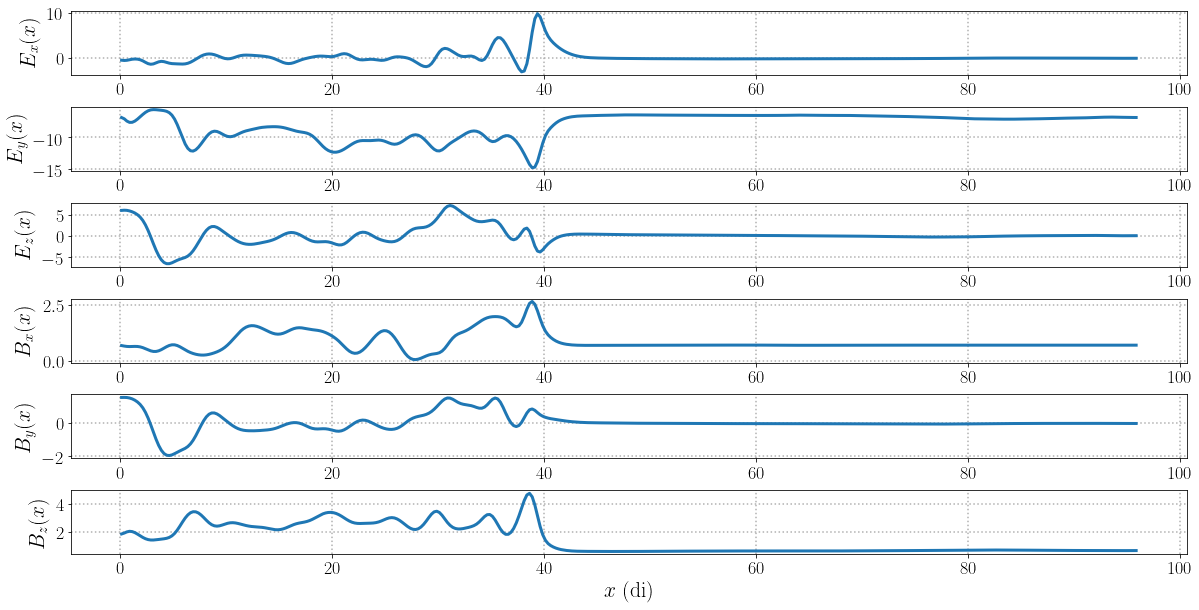

In [67]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

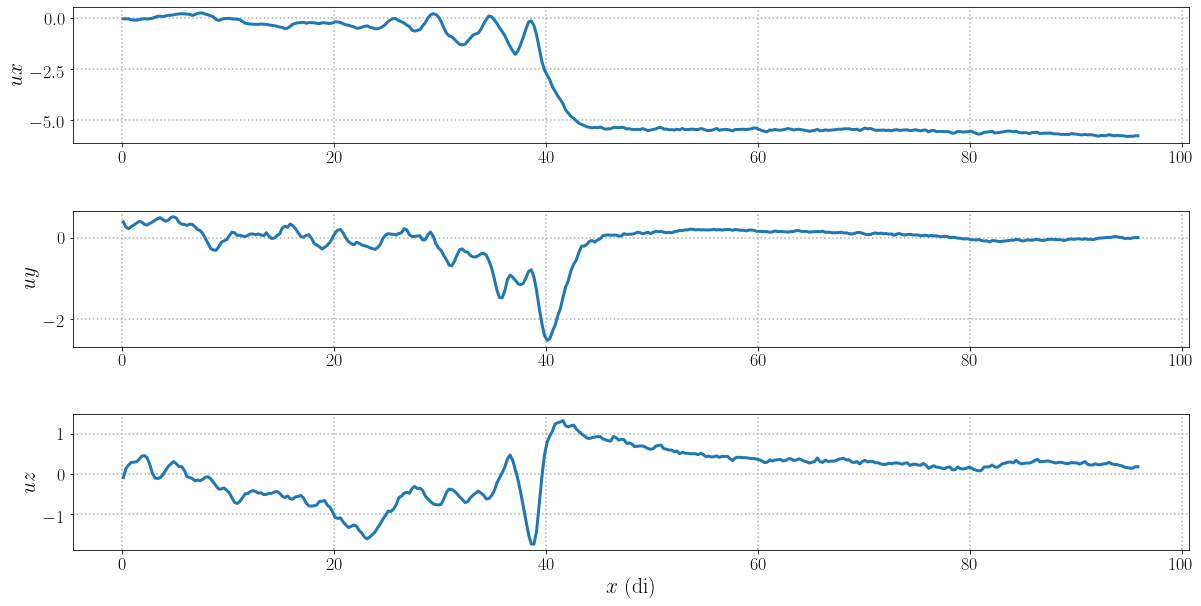

In [68]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [ ]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., xlim[0], xlim[1], ylim[0], ylim[1])

### Compute Shock Vel and Lorentz transform fields

In [32]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)


In [33]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


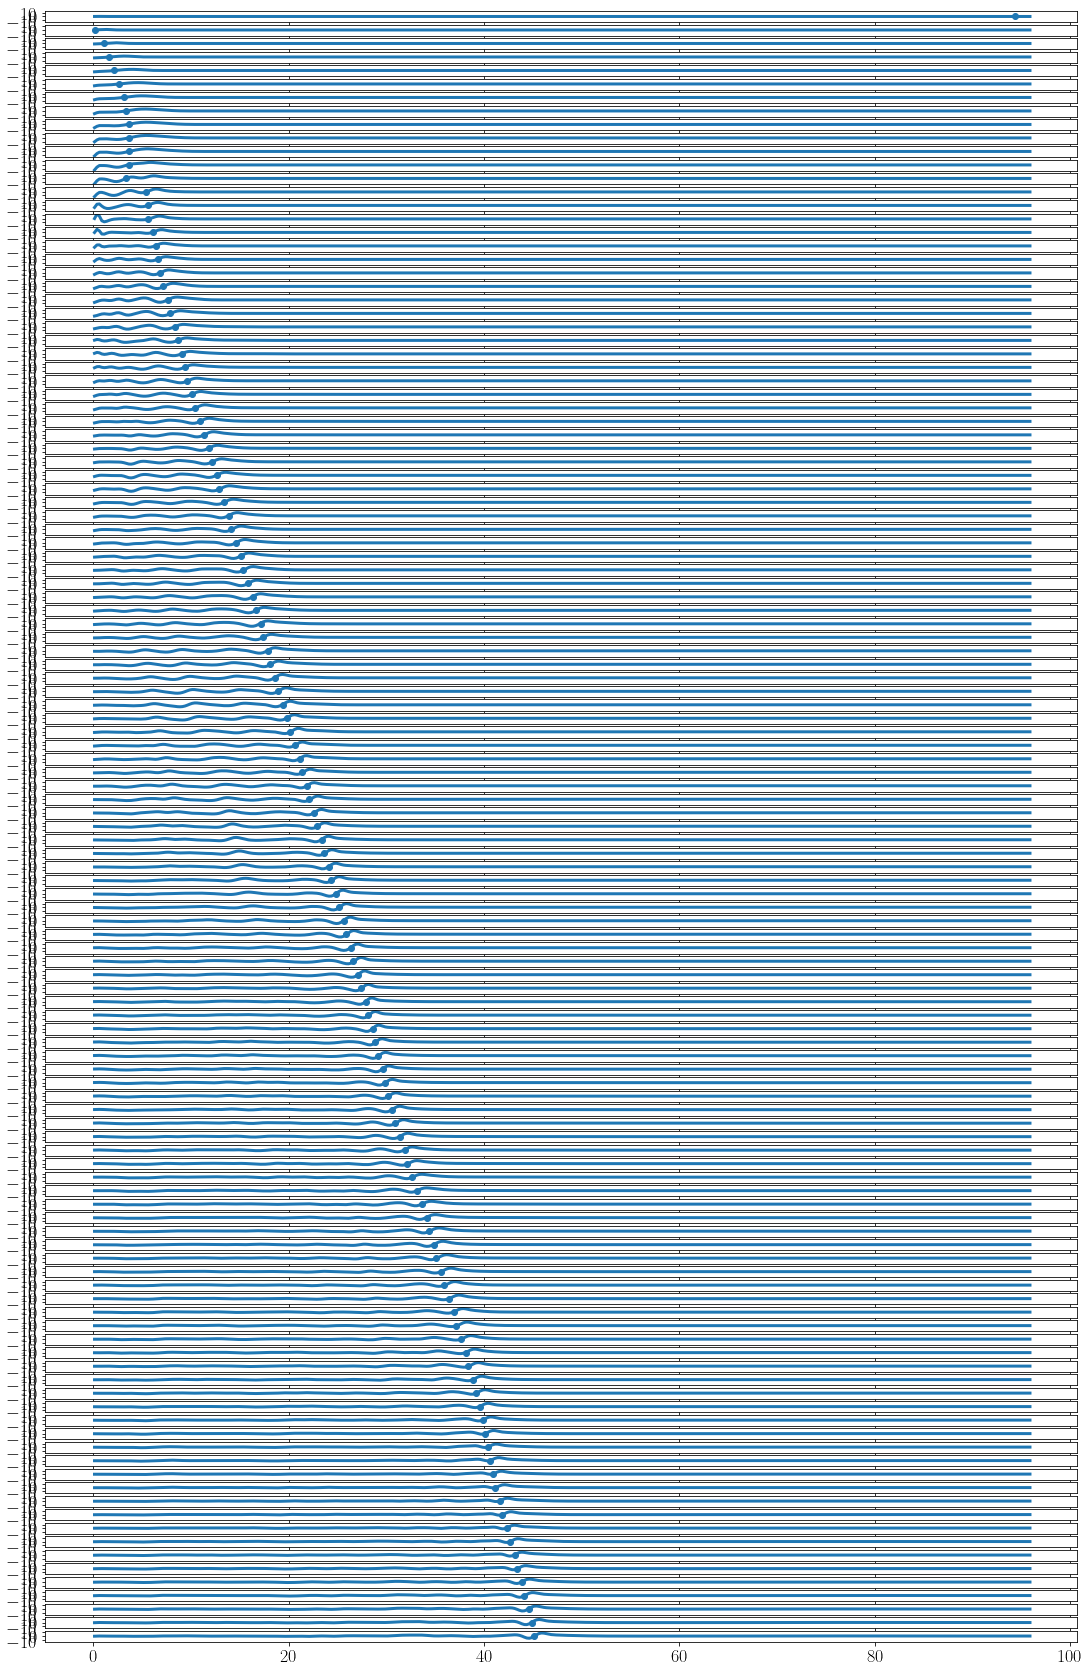

In [34]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [35]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

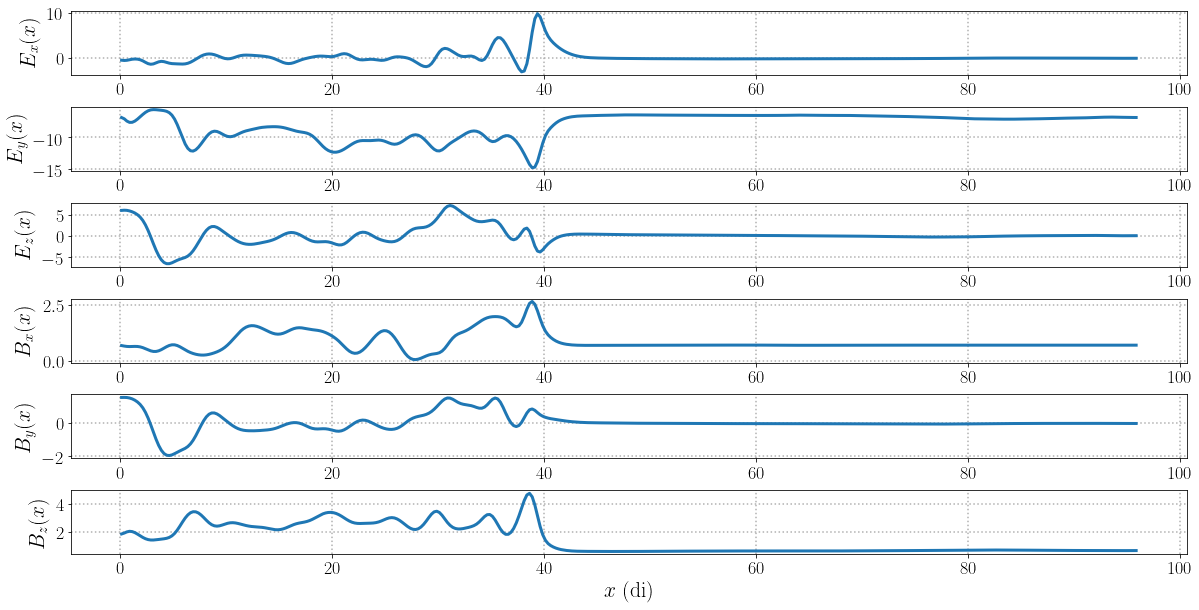

In [69]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

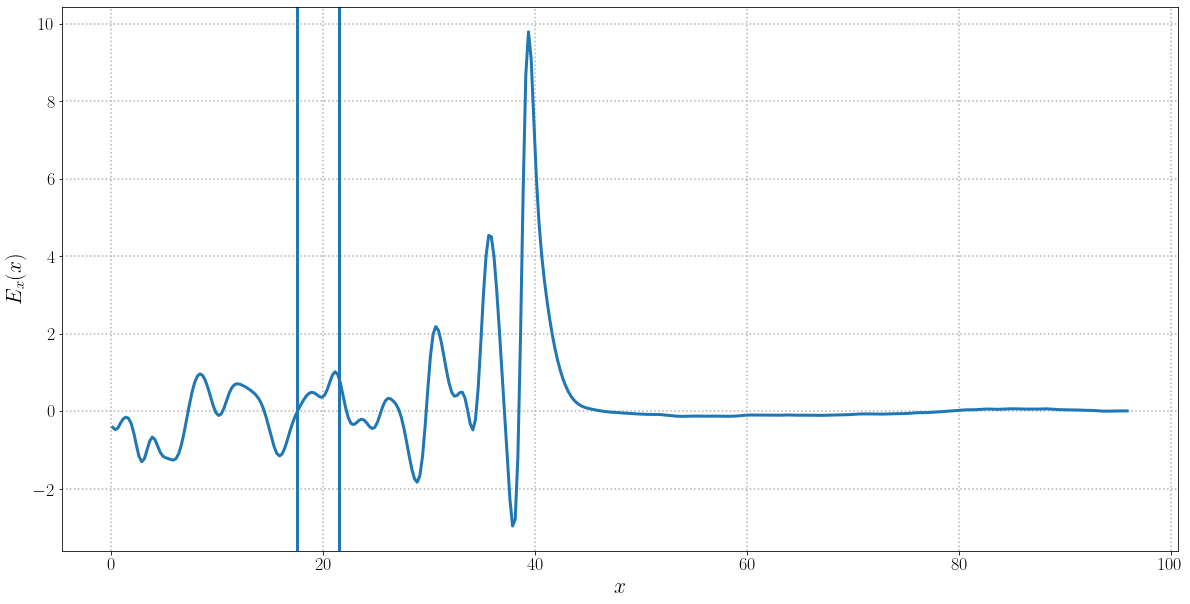

In [63]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.5#lower bound for metadata = 1 (di)
endval = 21.5 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
xlim

In [ ]:
metadata = md.build_metadata(xlim,dx, startval, endval)

In [ ]:
metadata

### Test super plot

In [121]:
x1 = xlim[0]
x2 = xlim[1]
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

UnboundLocalError: local variable 'dpar_p1' referenced before assignment

In [ ]:
totalPtcl

In [ ]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [ ]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock,xlim=xlim,ylim=ylim,zlim=zlim)

### Make superplot gif

In [ ]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

In [ ]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

### Convert to previous '2v FPC' formatting

In [ ]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_2v = []
CEy_2v = []
CEz_2v = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
    CEx_2v.append(CEx_xy)
    CEy_2v.append(CEy_xy)
    CEz_2v.append(CEz_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
x_out = x

#### Compute energization from correlations

In [ ]:
#TODO: project onto 2d plane and handle different projections net energization
#Also note, technically, we can project in this order, to compute energization,
#but it is a little confusing to follow
enerCEx_out = anl.compute_energization_over_x(CEx_2v,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_2v,dv)
enerCEz_out = anl.compute_energization_over_x(CEz_2v,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [ ]:
inputdict = dnc.parse_input_file(path)

In [ ]:
params = dnc.build_params(inputdict,numframe)

In [ ]:
inputdict

In [ ]:
params

In [ ]:
metadata

In [ ]:
savenewfmt = True
if(savenewfmt):
    flnm = '3Vtest1.nc'
    try:
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
else:
    flnm = '2Vtest.nc'
    try:
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [ ]:
if(savenewfmt):
    Hist_in, CEx_in, CEy_in, CEz_in, vx_in, vy_in, vz_in, x_in, enerCEx_in, enerCEy_in, enerCEz_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(flnm)
else:
    CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [ ]:
dfields['bz_zz']

In [ ]:
CEx_xy

In [ ]:
CEx_xy = [ao.array_3d_to_2d(CEx[i],'xy') for i in range(0,len(CEx))]
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.make_velsig_gif_with_EcrossB(vx_xy, vy_xy, vmax, CEx_xy, 'ex', x_out, dx, dfields, 'CExExB', 'CExExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CExExB', 'CExExB.gif')

<img src="CExExB.gif" width="750" align="center">

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_in, 'ex', x_out, dx, dfields, 'CEyExB', 'CEyExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CEyExB', 'CEyExB.gif')

<img src="CEyExB.gif" width="750" align="center">

##  Plot fields as a function of time

In [ ]:
#Plots Ex(x=xxpltpoint,y=0,z=0;t)
xxpltpoint = 20.0 #di
xxindex = ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [ ]:
anl.get_abs_max_velocity(dparticles)

### Test making field pmesh

In [ ]:
xxindex = 164
plt2d.make_field_pmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

In [ ]:
xx = 40.0
xxindex = ao.find_nearest(dfields['ex_xx'], xx)
plt2d.compare_pmesh_fields_yz(dfields, flnm = '', ttl ='x (di): ' + str(dfields['ex_xx'][xxindex]), takeaxisaverage=False, xxindex=xxindex)

In [ ]:
plt2d.compare_pmesh_fields_yz_sweep(dfields,'pmeshsweep')

In [ ]:
rsltmng.make_gif_from_folder('pmeshsweep', 'pmeshsweep.gif')

### Estimate Ripple size

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

### Test 2d fourier (WIP)

In [ ]:
startval = 39.
endval = 40.5
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pltfr.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

### Test Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
dflowtransform = ft.transform_flow(dflow,vshock)
pltdebug.check_JiEi_vs_CEi(dfields,dflowtransform,dparticles,x_in,enerCEx_in,enerCEy_in,dx,xlim=xlim,ylim=ylim,zlim=zlim)

In [ ]:
dflowtransform['Vframe_relative_to_sim']

In [ ]:
vshock

In [ ]:
dfields['Vframe_relative_to_sim']

### Test averaging out shock event

In [ ]:
def remove_average_fields_over_yz(dfields):
    from copy import copy

    dfieldfluc = copy(dfields) #deep copy
    dfieldfluc['ex'] = dfields['ex']-dfields['ex'].mean(axis=(0,1))
    dfieldfluc['ey'] = dfields['ey']-dfields['ey'].mean(axis=(0,1))
    dfieldfluc['ez'] = dfields['ez']-dfields['ez'].mean(axis=(0,1))
    dfieldfluc['bx'] = dfields['bx']-dfields['bx'].mean(axis=(0,1))
    dfieldfluc['by'] = dfields['by']-dfields['by'].mean(axis=(0,1))
    dfieldfluc['bz'] = dfields['bz']-dfields['bz'].mean(axis=(0,1))
    
    return dfieldfluc
    

In [37]:
dfieldfluc = remove_average_fields_over_yz(dfields)

In [ ]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)#,lowxlim=15,highxlim=25)

In [ ]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0,lowxlim=35,highxlim=45)

In [ ]:
import matplotlib.pyplot as plt
def compare_fields(dfields1, dfields2, fieldkey, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = ''):
    """
 
    """


    if(axis == '_zz'):
        fieldval1 = np.asarray([dfields1[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'z'
    elif(axis == '_yy'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'y'
    elif(axis == '_xx'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'x'

    fieldcoord1 = np.asarray(dfields1[fieldkey+axis])
    fieldcoord2 = np.asarray(dfields2[fieldkey+axis])

    plt.figure(figsize=(20,10))
    plt.xlabel(xlbl)
    plt.ylabel(fieldkey)
    plt.plot(fieldcoord1,fieldval1)
    plt.plot(fieldcoord2,fieldval2)
    if(not(axvx1 != axvx1)): #if not nan
        plt.axvline(x=axvx1)
    if(not(axvx2 != axvx2)): #if not nan
        plt.axvline(x=axvx2)
    if(flnm == ''):
        plt.show()
    else:
        plt.savefig(flnm,format='png')
    plt.close()

In [ ]:
compare_fields(dfields, dfieldfluc, 'ex', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ey', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ez', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bx', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'by', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bz', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ex')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ey')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ez')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'bx')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'by')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'bz')

### Do fourier sweeps

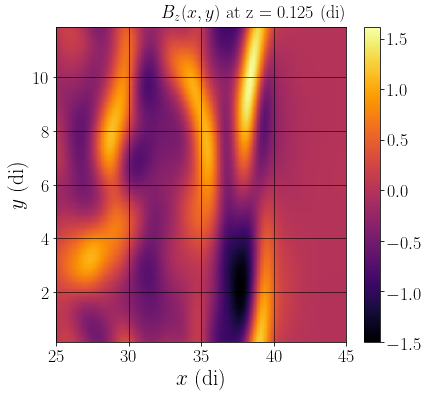

In [95]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=25,xlimmax=45)

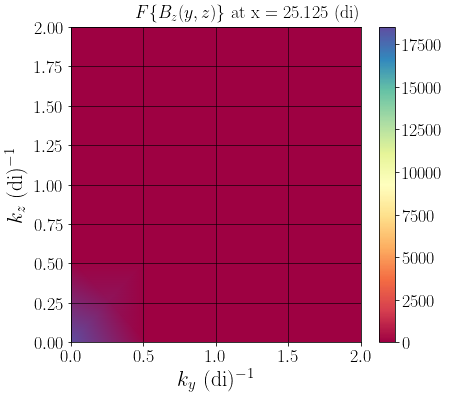

In [118]:
pltfr.plot_fft_norm(dfields,'bz','yz',flnm = '',takeaxisaverage=False, xxindex=100, yyindex=float('nan'), zzindex=float('nan'), plotlog = False,xaxislim=2,yaxislim=2)

In [49]:
xaxislim=5
yaxislim=5
pltfr.make_2dfourier_sweep(dfields,'bz','yz','fourierswptest',plotlog=False,xaxislim=xaxislim,yaxislim=yaxislim)

Making plot 0 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776 

Making plot 2 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776 

Making plot 4 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776 

Making plot 6 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776 

Making plot 8 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776 

Making plot 10 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 12 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 14 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 16 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 18 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 20 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 22 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 24 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 26 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 28 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 30 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 32 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 34 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 36 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 38 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 40 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 42 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 44 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 46 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 48 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 50 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 52 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 54 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 56 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 58 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 60 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 62 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

xlim test
5
Making plot 64 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898

Making plot 66 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 68 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 70 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 72 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 74 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 76 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 78 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 80 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 82 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 84 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 86 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 88 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 90 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 92 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 94 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 96 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 98 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776

Making plot 100 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 102 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 104 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 106 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 108 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 110 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 112 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 114 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 116 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 118 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 120 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 122 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 124 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 126 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 128 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 130 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 132 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 134 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 136 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 138 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 140 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 142 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 144 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 146 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 148 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 150 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 152 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 154 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 156 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 158 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 160 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 162 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 164 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 166 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 168 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 170 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 172 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 174 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 176 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 178 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 180 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 182 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 184 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 186 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 188 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 190 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 192 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 194 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 196 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 198 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 200 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 202 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 204 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 206 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 208 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 210 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 212 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 214 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 216 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 218 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 220 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 222 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 224 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 226 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 228 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 230 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 232 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 234 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 236 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 238 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 240 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 242 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 244 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 246 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 248 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 250 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 252 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 254 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 256 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 258 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 260 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 262 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 264 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 266 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 268 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 270 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 272 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 274 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 276 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 278 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 280 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 282 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 284 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 286 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 288 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 290 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 292 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 294 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 296 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 298 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 300 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 302 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 304 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 306 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 308 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 310 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 312 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 314 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 316 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 318 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 320 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 322 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 324 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 326 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 328 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 330 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 332 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 334 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 336 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 338 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 340 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 342 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 344 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 346 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 348 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 350 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 352 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 354 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 356 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 358 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 360 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 362 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 364 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 366 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 368 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 370 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 372 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 374 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 376 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 378 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 380 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

Making plot 382 of 384
[[ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.23598776  5.75958653  6.28318531
   6.80678408  7.33038286  7.85398163  8.37758041  8.90117919  9.42477796
   9.94837674 10.47197551 10.99557429 11.51917306 12.04277184]
 [ 0.52359878  1.04719755  1.57079633  2.0943951   2.61799388  3.14159265
   3.66519143  4.1887902   4.71238898  5.2359877

In [50]:
rsltmng.make_gif_from_folder('fourierswptest', 'fourierswptest.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

### Compare FPCs

In [ ]:
pltdebug.plot_1d_dist(dparticles, 'x1', 35., xlim[0], xlim[1], ylim[0], ylim[1])

In [ ]:
dparticles

In [ ]:
print(xlim,ylim,zlim)

In [ ]:
x1 = 24.0
x2 = 27.0
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

In [ ]:
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Above is with original fields. Below is average subtracted fields

In [ ]:
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Make sweep gif for presentation

In [47]:
plt1d.make_field_scan_gif(dfields, 'ex', 'scantest', axis='_xx')

Making plot 0 of 384
Making plot 1 of 384
Making plot 2 of 384
Making plot 3 of 384
Making plot 4 of 384
Making plot 5 of 384
Making plot 6 of 384
Making plot 7 of 384
Making plot 8 of 384
Making plot 9 of 384
Making plot 10 of 384
Making plot 11 of 384
Making plot 12 of 384
Making plot 13 of 384
Making plot 14 of 384
Making plot 15 of 384
Making plot 16 of 384
Making plot 17 of 384
Making plot 18 of 384
Making plot 19 of 384
Making plot 20 of 384
Making plot 21 of 384
Making plot 22 of 384
Making plot 23 of 384
Making plot 24 of 384
Making plot 25 of 384
Making plot 26 of 384
Making plot 27 of 384
Making plot 28 of 384
Making plot 29 of 384
Making plot 30 of 384
Making plot 31 of 384
Making plot 32 of 384
Making plot 33 of 384
Making plot 34 of 384
Making plot 35 of 384
Making plot 36 of 384
Making plot 37 of 384
Making plot 38 of 384
Making plot 39 of 384
Making plot 40 of 384
Making plot 41 of 384
Making plot 42 of 384
Making plot 43 of 384
Making plot 44 of 384
Making plot 45 of 38

Making plot 361 of 384
Making plot 362 of 384
Making plot 363 of 384
Making plot 364 of 384
Making plot 365 of 384
Making plot 366 of 384
Making plot 367 of 384
Making plot 368 of 384
Making plot 369 of 384
Making plot 370 of 384
Making plot 371 of 384
Making plot 372 of 384
Making plot 373 of 384
Making plot 374 of 384
Making plot 375 of 384
Making plot 376 of 384
Making plot 377 of 384
Making plot 378 of 384
Making plot 379 of 384
Making plot 380 of 384
Making plot 381 of 384
Making plot 382 of 384
Making plot 383 of 384


In [48]:
rsltmng.make_gif_from_folder('scantest', 'scantest.gif')

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049', '000050', '000051', '000052', '000053', '000054', '000055', '000056', '000057', '000058', '000059', '000060', '000061', '000062', '000063', '000064', '000065', '000066', '000067', '000068', '000069', '000070', '000071', '000072', '000073', '000074', '000075', '000076', '000077', '000078', '000079', '000080', '000081', '000082', '000083', '000084', '000085', '000086', '000087', '000088', '000089', '000090', '000091', '000092', '000093', '000094', '000095', '000096', '000097', '000098', '000099',